In [35]:
import numpy as np
import rawpy


def pack_raw(raw, black_level=512, white_level=16383, normalize=True):
    """Packs Bayer image to 4 channels"""

    img = raw.raw_image_visible
    img = np.expand_dims(img, axis=2)

    out = np.concatenate((img[0::2, 0::2], # R
                          img[0::2, 1::2], # G
                          img[1::2, 1::2], # B
                          img[1::2, 0::2], # G
                          ), axis=2)
    
    if normalize:
        out = (out - black_level) / (white_level - black_level) * 255.0
        out = out.astype(np.uint8)

    return out

def unpack_raw(raw, packed_img, black_level=512, white_level=16383):
    H = 2 * packed_img.shape[0]
    W = 2 * packed_img.shape[1]

    packed_img = packed_img / 255.0 * (white_level - black_level) + black_level
    packed_img = packed_img.astype(np.uint16)

    out = np.zeros((H, W), dtype=np.uint16)
    out[0:H:2, 0:W:2] = packed_img[:, :, 0]
    out[0:H:2, 1:W:2] = packed_img[:, :, 1]
    out[1:H:2, 1:W:2] = packed_img[:, :, 2]
    out[1:H:2, 0:W:2] = packed_img[:, :, 3]
    
    raw.raw_image_visible[0:H:2, 0:W:2] = packed_img[:, :, 0]
    raw.raw_image_visible[0:H:2, 1:W:2] = packed_img[:, :, 1]
    raw.raw_image_visible[1:H:2, 1:W:2] = packed_img[:, :, 2]
    raw.raw_image_visible[1:H:2, 0:W:2] = packed_img[:, :, 3]

    return raw, out

In [36]:
original_image_raw = rawpy.imread('first-filter-dataset/IMG_7957.CR2')
diffused_image_raw = rawpy.imread('first-filter-dataset/IMG_7955_diff.CR2')

packed_original = pack_raw(original_image_raw)
packed_diffused = pack_raw(diffused_image_raw)

unpacked_image_raw, unpacked_image_array = unpack_raw(original_image_raw, packed_original)


In [3]:
import cv2

def get_images_alignment_transform(img1, img2):
    orb = cv2.ORB_create(nfeatures=5000)

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, mask=None)
    kp2, des2 = orb.detectAndCompute(img2, mask=None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Use RANSAC to find homography
    if len(matches) > 10:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)
        return H
    else:
        raise ValueError("Not enough matches found.")

def apply_transform(img1, img2, H):
    aligned_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
    return aligned_img

def align_images_single_channel(img1, img2):
    """Aligns img2 to img1 using ORB feature matching and RANSAC."""
    orb = cv2.ORB_create(nfeatures=5000)

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, mask=None)
    kp2, des2 = orb.detectAndCompute(img2, mask=None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Use RANSAC to find homography
    if len(matches) > 10:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)
        
        # Warp img2 to align with img1 (preserving colors)
        aligned_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
        
        return aligned_img, H
    else:
        raise ValueError("Not enough matches found.")


In [4]:
def align_images_raw(path1, path2):
    """Aligns img2 to img1 channel by channel"""
    raw1 = rawpy.imread(path1)
    raw2 = rawpy.imread(path2)

    packed1 = pack_raw(raw1)
    packed2 = pack_raw(raw2)

    aligned_channels = []
    projection_matrices = []
    
    # Calculate projections for each color channel individually
    for c in range(4):
        img1 = packed1[:, :, c]
        img2 = packed2[:, :, c]
        projection_matrix = get_images_alignment_transform(img1, img2)
        projection_matrices.append(projection_matrix)

    projection_matrix = np.stack(projection_matrices, axis=2).mean(axis=2)

    for c in range(4):
        img1 = packed1[:, :, c]
        img2 = packed2[:, :, c]
        aligned_ch = apply_transform(img1, img2, projection_matrix)
        aligned_channels.append(aligned_ch)

    aligned_channels = np.stack(aligned_channels, axis=2, dtype=np.float32)

    # TODO: check projection matrices
    # TODO: crop original image
    # TODO: intensity alignment

    raw = rawpy.imread(path1)
    aligned_image_raw, aligned_image_array = unpack_raw(raw, aligned_channels)

    return aligned_image_raw, aligned_image_array, aligned_channels

In [5]:
aligned_raw, aligned_image, aligned_channels = align_images_raw(
    'first-filter-dataset/IMG_7957.CR2',
    'first-filter-dataset/IMG_7955_diff.CR2'
)

#aligned_raw, aligned_image, aligned_channels = align_images_raw(
#    'first-dataset/first-dataset-RAW/IMG_7781.CR2',
#    'first-dataset/first-dataset-RAW/IMG_7782.CR2'
#)


In [6]:
original_image_raw = rawpy.imread('first-filter-dataset/IMG_7957.CR2')
diffused_image_raw = rawpy.imread('first-filter-dataset/IMG_7955_diff.CR2')



In [7]:
plt.imshow(aligned_raw.postprocess())


NameError: name 'plt' is not defined

In [8]:
def compute_local_variance_single_channel(image, kernel_size=5):
    image = image.astype(np.float32)
    mean = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    mean_sq = cv2.GaussianBlur(image**2, (kernel_size, kernel_size), 0)
    #variance = np.clip(mean_sq - mean**2, 0, 1)
    return mean_sq - mean**2

def compute_local_variance(image, kernel_size=5):
    R_variance = compute_local_variance_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_variance_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_variance_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_variance_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)


In [9]:
aligned_variance = compute_local_variance(aligned_channels)


In [40]:
packed_original = pack_raw(original_image_raw, normalize=False)
original_variance = compute_local_variance(packed_original)

In [11]:
variance_difference = np.abs(aligned_variance - original_variance)

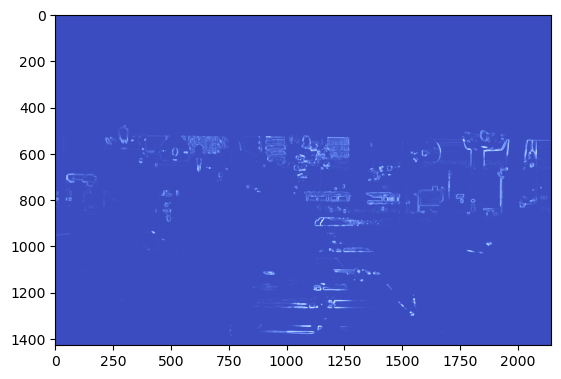

In [14]:
from matplotlib import pyplot as plt

plt.imshow(variance_difference[:, :, 1], cmap="coolwarm")


In [25]:
def create_dict_per_pair(long_raw, noise_raw):
    long_raw = long_raw.flatten()
    noise_raw = noise_raw.flatten()
    dict_noise = {}
    for i in range(long_raw.shape[0]):
        if long_raw[i] not in dict_noise:
            dict_noise[long_raw[i]] = []
        dict_noise[long_raw[i]].append(noise_raw[i])
    return dict_noise


In [41]:
packed_original.max()

16071

In [42]:
variance_difference_by_pixel_R = create_dict_per_pair(packed_original[:, :, 0], variance_difference)

In [45]:
variance_difference_by_pixel_R

{1009: [0.0,
  0.0,
  0.1875,
  0.0,
  0.030273438,
  0.0,
  0.18353271,
  0.0,
  0.109375,
  0.007751465,
  0.18353271,
  0.0,
  0.15234375,
  0.030273438,
  0.19506836,
  0.007751465,
  0.13183594,
  0.044677734,
  0.17944336,
  0.030273438,
  0.13183594,
  0.030273438,
  0.10345459,
  0.044677734,
  0.15234375,
  0.007751465,
  0.022888184,
  0.030273438,
  0.109375,
  0.0,
  0.0,
  0.007751465,
  0.030273438,
  0.0,
  0.022888184,
  0.0,
  0.0,
  0.0,
  0.10345459,
  0.0,
  0.0,
  0.17944336,
  0.0,
  0.030273438,
  0.0,
  0.17944336,
  0.022888184,
  0.109375,
  0.0,
  0.10345459,
  0.08496094,
  0.15234375,
  0.0,
  0.022888184,
  0.12084961,
  0.101623535,
  0.0,
  0.0,
  0.08496094,
  0.035095215,
  0.0,
  0.0,
  0.022888184,
  0.16186523,
  0.022888184,
  0.0,
  0.0,
  0.19506836,
  0.09124756,
  0.0,
  0.0,
  0.137146,
  0.14233398,
  0.022888184,
  0.0,
  0.03753662,
  0.12084961,
  0.08496094,
  0.0,
  0.0,
  0.051696777,
  0.12084961,
  0.0,
  0.0,
  0.007751465,
  0.08496

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example dictionary: x (bins) -> list of y values
data = variance_difference_by_pixel_R

# Extract x values (bins) and compute mean y for each bin
#x_values = np.array(list(data.keys()))
#y_means = np.array([np.mean(y_list) for y_list in data.values()])

# Scatter plot: All y-values per bin
for x, y_list in data.items():
    plt.scatter([x] * len(y_list), y_list, color='blue', alpha=0.5)

# Fit a linear regression line
#slope, intercept = np.polyfit(x_values, y_means, 1)
#y_fit = slope * x_values + intercept

# Plot the mean values and regression line
#plt.scatter(x_values, y_means, color='red', label="Mean per bin")
#plt.plot(x_values, y_fit, color='green', linestyle="--", label="Fit line")

# Labels and legend
plt.xlabel("X (Bins)")
plt.ylabel("Y Values")
plt.title("Bin Plot with Linear Fit")
plt.legend()
plt.grid(True)
plt.show()
